In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [16]:
# def csv_to_parquet(csv_path, save_name):
#     df = pd.read_csv(csv_path)
#     df.to_parquet(f'./data/{save_name}.parquet')
#     del df
#     gc.collect()
#     print(save_name, 'Done.')

In [17]:
# csv_to_parquet('./data/train.csv', 'train')
# csv_to_parquet('./data/test.csv', 'test')

In [18]:
# train = pd.read_parquet('./data/train.parquet')
# test = pd.read_parquet('./data/test.parquet')

### 데이터 불러오기

In [58]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [26]:
train[30:40]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
30,TRAIN_0000030,20220623,1,6,2,107,-,0,0,80.0,...,0,일호유리,33.472276,126.418443,0,상귀교차로,33.473390,126.409129,0,75.0
31,TRAIN_0000031,20211028,1,15,1,107,-,0,0,60.0,...,3,남수교,33.337244,126.695809,0,남수교,33.337398,126.696117,0,36.0
32,TRAIN_0000032,20211018,3,16,1,103,일반국도16호선,0,0,50.0,...,0,남읍학교살리기다가구,33.439180,126.329386,0,고산전화국,33.437936,126.327938,0,28.0
33,TRAIN_0000033,20220522,4,22,3,103,일반국도12호선,0,0,50.0,...,3,거로마을,33.514390,126.555913,0,별도교,33.513709,126.554483,0,26.0
34,TRAIN_0000034,20211205,4,9,1,107,-,0,0,60.0,...,3,남수교,33.337398,126.696117,0,남수교,33.337244,126.695809,0,54.0
35,TRAIN_0000035,20220523,3,12,2,107,태평로,0,0,50.0,...,0,서현주택,33.245565,126.566228,0,팔도철물건재,33.245375,126.565805,0,21.0
36,TRAIN_0000036,20220525,2,11,1,106,지방도1120호선,0,0,50.0,...,3,명월교,33.393972,126.263060,0,명월교,33.394228,126.263042,0,35.0
37,TRAIN_0000037,20220702,5,19,3,103,일반국도16호선,0,0,50.0,...,0,연동사거리,33.485704,126.496451,0,신제주초교입구오거리,33.483589,126.496368,1,24.0
38,TRAIN_0000038,20220610,0,8,2,107,삼무로,0,0,50.0,...,0,제주일보사거리,33.490078,126.486558,1,삼무공원사거리,33.489940,126.490153,0,10.0
39,TRAIN_0000039,20210917,0,11,3,103,일반국도11호선,0,0,70.0,...,0,인다마을,33.471061,126.545467,0,아라주공아파트,33.473494,126.545647,0,21.0


확인 해볼거
- 요일별(공휴일), 시간대별, 거리별 
- 전체 지도별 도로 표시
- 추이 그래프
- 년도/월/일별 추이 그래프
- 컬럼이 너무 많아서 각 컬럼별 상관계수

### 년도/월/일별 추이 그래프

In [121]:
train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')

In [122]:
train['base_date'].min()

20210901

In [123]:
train['base_date'].max()

20220731

### 

In [124]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_name = train[['road_name','target']]
train_name = train_name.groupby('road_name').mean().reset_index()

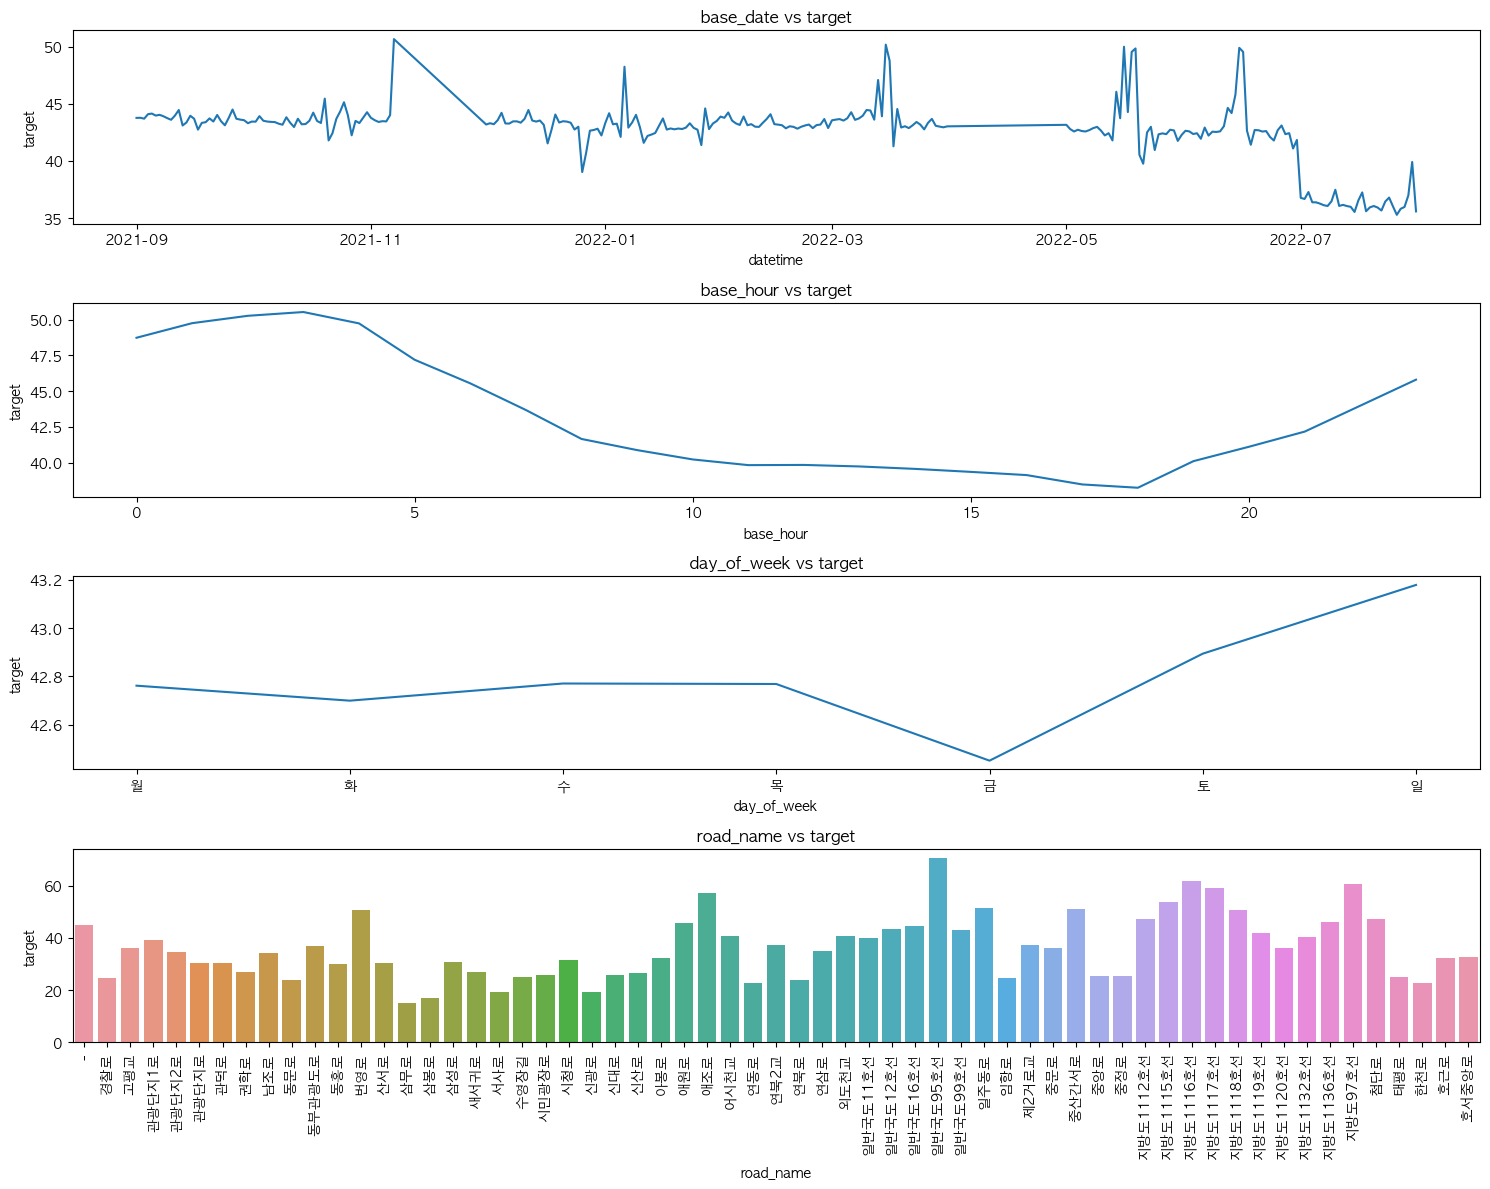

In [26]:
fig, axes = plt.subplots(4, figsize=(15,12))

sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')
sns.barplot(x='road_name',y='target',data=train_name,ax=axes[3]).set(title='road_name vs target')

plt.rcParams['font.family'] = 'Heiti TC'
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 공휴일 시각화

공휴일 데이터 불러오기

In [111]:
def get_holiday_data(year):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
    params = {
        'serviceKey': 'lUyD7/c6oiXRywzql7NJsMdnhrTjYOH+Rx/4siN3lV2/J2bWu4UfjpTnBTl150QccIo/8rglYGnTQW2XaKH81g==',
        'solYear': str(year),
        'numOfRows': '100' 
    }

    response = requests.get(url, params=params)
    xml_data = response.content
    json_data = json.dumps(xmltodict.parse(xml_data), indent=4)

    data = json.loads(json_data)

    items = data['response']['body']['items']['item']
    holiday_data = pd.DataFrame(items)

    return holiday_data

holiday_2021 = get_holiday_data(2021)
holiday_2022 = get_holiday_data(2022)

holiday_data = pd.concat([holiday_2021, holiday_2022],ignore_index=True)[['dateName','locdate']]
holiday_data["datetime"] = pd.to_datetime(holiday_data["locdate"],format='%Y%m%d')

holiday_data.head(10)
# holiday_data.to_csv('./data/holiday.csv', index=False)

,dateName,locdate,datetime
0,1월1일,20210101,2021-01-01
1,설날,20210211,2021-02-11
2,설날,20210212,2021-02-12
3,설날,20210213,2021-02-13
4,삼일절,20210301,2021-03-01
5,어린이날,20210505,2021-05-05
6,부처님오신날,20210519,2021-05-19
7,현충일,20210606,2021-06-06
8,광복절,20210815,2021-08-15
9,대체공휴일,20210816,2021-08-16


In [150]:
# 공휴일이면 is_holiday에 'Y' 값 표시
train['is_holiday'] = train['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})


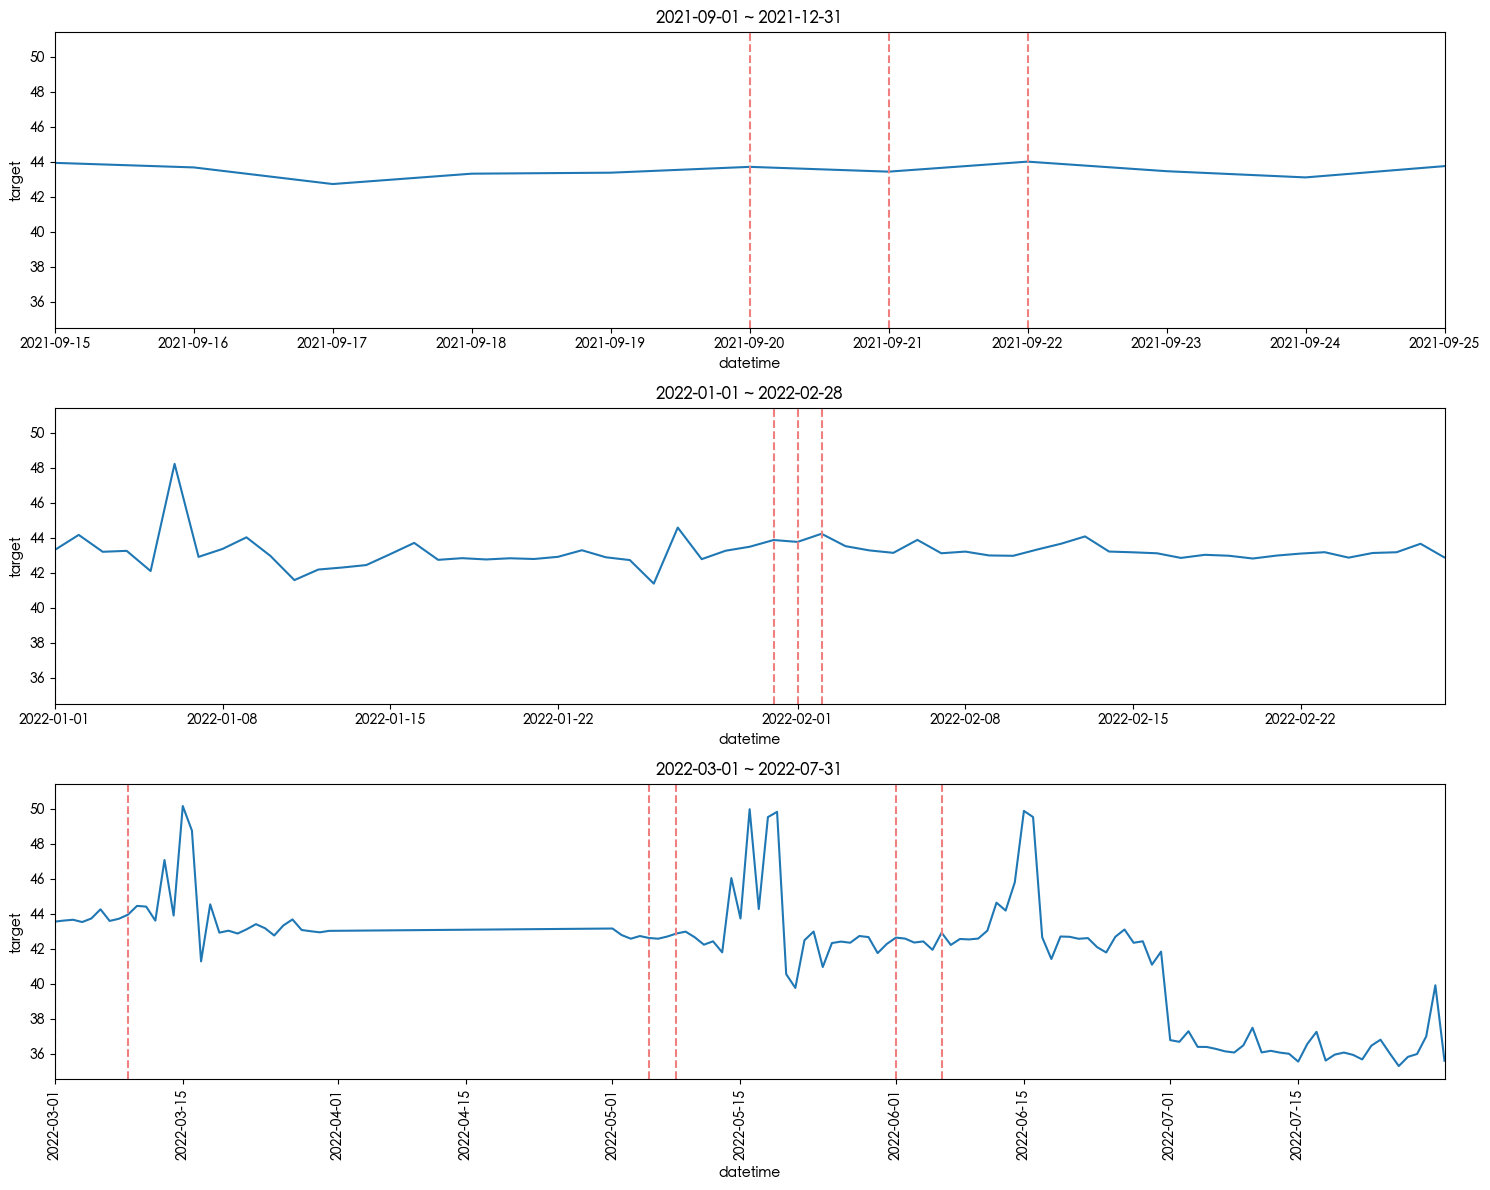

In [158]:
from datetime import datetime

train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()
train_date['is_holiday'] = train_date['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

fig, axes = plt.subplots(3, figsize=(15,12))
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='2021-09-01 ~ 2021-12-31')
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[1]).set(title='2022-01-01 ~ 2022-02-28')
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[2]).set(title='2022-03-01 ~ 2022-07-31')

axes[0].set_xlim([datetime(2021, 9, 15), datetime(2021, 9, 25)])
axes[1].set_xlim([datetime(2022, 1, 1), datetime(2022, 2, 28)])
axes[2].set_xlim([datetime(2022, 3, 1), datetime(2022, 7, 31)])

for ax in axes:
    for _, row in train_date[train_date['is_holiday'] == 'Y'].iterrows():
        ax.axvline(x=row['datetime'], color='lightcoral', linestyle='--')

plt.rcParams['font.family'] = 'Heiti TC'
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 데이터 전처리

In [6]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [7]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


### 모델 선언 및 학습

In [8]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

### 추론

In [10]:
pred = LR.predict(test)

### Submission

In [12]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [13]:
sample_submission['target'] = pred
sample_submission.to_csv("./data/submit.csv", index = False)

In [14]:
sample_submission

,id,target
0,TEST_000000,27.298710
1,TEST_000001,43.949243
2,TEST_000002,60.552621
3,TEST_000003,36.499322
4,TEST_000004,37.510570
...,...,...
291236,TEST_291236,45.902276
291237,TEST_291237,52.604831
291238,TEST_291238,21.964371
291239,TEST_291239,25.402628
